# Layoff Prediction Demo - Quarterly Risk Assessment

This notebook demonstrates how to use the trained XGBoost model to predict layoff risk for publicly-traded companies at the quarterly level.

**Prediction Goal:** Classify companies as High Risk (1) or Low Risk (0) for layoffs in the current quarter.

**Input:** Company-quarter financial and economic data

**Output:** Layoff risk predictions with probabilities

## 1. Load Saved Model and Components

In [17]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Loading saved model components...\n")

with open('../models/best_xgb_quarterly_regularized.pkl', 'rb') as f:
    model = pickle.load(f)
    print("Model loaded")

with open('../models/scaler_quarterly.pkl', 'rb') as f:
    scaler = pickle.load(f)
    print("Scaler loaded")

with open('../models/feature_names_quarterly.pkl', 'rb') as f:
    feature_names = pickle.load(f)
    print("Feature names loaded")

with open('../models/optimal_threshold_quarterly.pkl', 'rb') as f:
    optimal_threshold = pickle.load(f)
    print(f"Optimal threshold loaded: {optimal_threshold:.3f}")

print(f"\nModel details:")
print(f"  Type: XGBoost Classifier")
print(f"  Features: {len(feature_names)}")
print(f"  Prediction level: Company-Quarter")
print(f"  Optimization: AUPRC")

Loading saved model components...

Model loaded
Scaler loaded
Feature names loaded
Optimal threshold loaded: 0.284

Model details:
  Type: XGBoost Classifier
  Features: 55
  Prediction level: Company-Quarter
  Optimization: AUPRC


## 2. Load Sample Data for Prediction

We'll use the most recent quarters from our test set as demonstration data.

In [18]:
df_sample = pd.read_csv('../data/layoffs_modeling_ready.csv')
df_sample['Date'] = pd.to_datetime(df_sample['Date'])

recent_quarters = df_sample[df_sample['Date'] >= '2023-07-01'].copy()

print(f"Sample data for prediction:")
print(f"  Shape: {recent_quarters.shape}")
print(f"  Companies: {recent_quarters['Company'].nunique()}")
print(f"  Quarters: {recent_quarters['Date'].nunique()}")
print(f"  Date range: {recent_quarters['Date'].min().date()} to {recent_quarters['Date'].max().date()}")

print(f"\nActual layoff distribution in sample:")
print(recent_quarters['Layoff_Event_Binary'].value_counts())
print(f"Actual positive rate: {recent_quarters['Layoff_Event_Binary'].mean():.2%}")

print(f"\nSample companies:")
print(sorted(recent_quarters['Company'].unique())[:10])

Sample data for prediction:
  Shape: (608, 62)
  Companies: 152
  Quarters: 4
  Date range: 2023-07-01 to 2024-04-01

Actual layoff distribution in sample:
0.0    507
1.0    101
Name: Layoff_Event_Binary, dtype: int64
Actual positive rate: 16.61%

Sample companies:
['2u', '8x8', 'absolute software', 'acxiom', 'adaptive biotechnologies', 'adobe', 'akamai', 'alteryx', 'amazon', 'analog devices']


## 3. Prepare Features for Prediction

In [19]:
exclude_cols = ['Company', 'Date', 'year', 'quarter', 'year_quarter', 'Latest_Country', 'Layoff_Event_Binary']

X_sample = recent_quarters[feature_names]
y_actual = recent_quarters['Layoff_Event_Binary']

print(f"Features prepared:")
print(f"  Shape: {X_sample.shape}")
print(f"  Features: {len(feature_names)}")
print(f"  Missing values: {X_sample.isnull().sum().sum()}")

continuous_features = [col for col in feature_names if not col.startswith(('Industry_', 'Stage_', 'negative_', 'declining_')) and col != 'layoff_event_lag1']
binary_features = [col for col in feature_names if col.startswith(('Industry_', 'Stage_', 'negative_', 'declining_')) or col == 'layoff_event_lag1']

X_sample_continuous = scaler.transform(X_sample[continuous_features])
X_sample_scaled = np.hstack([X_sample_continuous, X_sample[binary_features].values])

print(f"\nFeatures scaled and ready for prediction")

Features prepared:
  Shape: (608, 55)
  Features: 55
  Missing values: 0

Features scaled and ready for prediction


## 4. Generate Predictions

In [20]:
y_pred_proba = model.predict_proba(X_sample_scaled)[:, 1]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

recent_quarters['Layoff_Risk_Score'] = y_pred_proba
recent_quarters['Predicted_Layoff'] = y_pred

print(f"Predictions generated!\n")
print(f"Prediction distribution:")
print(recent_quarters['Predicted_Layoff'].value_counts())
print(f"\nPredicted positive rate: {recent_quarters['Predicted_Layoff'].mean():.2%}")
print(f"Actual positive rate: {recent_quarters['Layoff_Event_Binary'].mean():.2%}")

Predictions generated!

Prediction distribution:
1    336
0    272
Name: Predicted_Layoff, dtype: int64

Predicted positive rate: 55.26%
Actual positive rate: 16.61%


## 5. View Predictions with Risk Scores

In [21]:
results_df = recent_quarters[['Company', 'Date', 'year_quarter', 'Layoff_Risk_Score', 
                              'Predicted_Layoff', 'Layoff_Event_Binary']].copy()

results_df['Risk_Category'] = pd.cut(results_df['Layoff_Risk_Score'], 
                                      bins=[0, 0.3, 0.6, 1.0],
                                      labels=['Low Risk', 'Medium Risk', 'High Risk'])

results_df = results_df.sort_values('Layoff_Risk_Score', ascending=False)

print("=== TOP 20 HIGHEST RISK COMPANIES ===")
print("\nCompanies most likely to have layoffs:\n")
display(results_df.head(20))

print("\n=== LOWEST RISK COMPANIES ===")
print("\nCompanies least likely to have layoffs:\n")
display(results_df.tail(10))

=== TOP 20 HIGHEST RISK COMPANIES ===

Companies most likely to have layoffs:



,Company,Date,year_quarter,Layoff_Risk_Score,Predicted_Layoff,Layoff_Event_Binary,Risk_Category
988,fisker,2024-01-01,2024-Q1,0.912667,1,1.0,High Risk
1942,pure storage,2024-01-01,2024-Q1,0.911242,1,1.0,High Risk
1994,rapid7,2023-07-01,2023-Q3,0.909136,1,1.0,High Risk
1904,planet,2023-07-01,2023-Q3,0.908891,1,1.0,High Risk
357,block,2023-10-01,2023-Q4,0.908541,1,1.0,High Risk
861,etsy,2023-10-01,2023-Q4,0.908541,1,1.0,High Risk
1004,fortinet,2023-07-01,2023-Q3,0.908541,1,1.0,High Risk
2660,zebra technologies,2023-07-01,2023-Q3,0.908514,1,1.0,High Risk
483,chewy,2023-10-01,2023-Q4,0.908514,1,1.0,High Risk
2356,tenable,2024-01-01,2024-Q1,0.908460,1,1.0,High Risk



=== LOWEST RISK COMPANIES ===

Companies least likely to have layoffs:



,Company,Date,year_quarter,Layoff_Risk_Score,Predicted_Layoff,Layoff_Event_Binary,Risk_Category
1617,nanostring technologies,2023-10-01,2023-Q4,0.119390,0,0.0,Low Risk
987,fisker,2023-10-01,2023-Q4,0.118878,0,0.0,Low Risk
951,f5,2023-10-01,2023-Q4,0.117899,0,1.0,Low Risk
753,e inc.,2023-10-01,2023-Q4,0.117072,0,0.0,Low Risk
1959,qualcomm,2023-10-01,2023-Q4,0.115528,0,1.0,Low Risk
2355,tenable,2023-10-01,2023-Q4,0.114069,0,0.0,Low Risk
1203,impinj,2023-10-01,2023-Q4,0.112725,0,0.0,Low Risk
1833,pegasystems,2023-10-01,2023-Q4,0.112725,0,0.0,Low Risk
51,absolute software,2023-10-01,2023-Q4,0.111859,0,0.0,Low Risk
1779,oracle,2023-10-01,2023-Q4,0.110465,0,0.0,Low Risk


## 6. Evaluate Prediction Performance

In [22]:
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred)
f2 = fbeta_score(y_actual, y_pred, beta=2)
cm = confusion_matrix(y_actual, y_pred)

print("=== PREDICTION PERFORMANCE ===")
print(f"\nAccuracy: {accuracy:.2%}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Score: {f2:.4f} (emphasizes recall)")

print(f"\nConfusion Matrix:")
print(cm)
print(f"\n  True Negatives: {cm[0,0]}")
print(f"  False Positives: {cm[0,1]} (predicted layoff, but didn't happen)")
print(f"  False Negatives: {cm[1,0]} (missed actual layoffs)")
print(f"  True Positives: {cm[1,1]} (correctly predicted layoffs)")

recall = cm[1,1] / (cm[1,1] + cm[1,0])
precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0

print(f"\nRecall: {recall:.2%} (caught {cm[1,1]} out of {cm[1,1] + cm[1,0]} actual layoffs)")
print(f"Precision: {precision:.2%} ({cm[1,1]} correct out of {cm[1,1] + cm[0,1]} predictions)")

print(f"\nClassification Report:")
print(classification_report(y_actual, y_pred, target_names=['No Layoff', 'Layoff']))

=== PREDICTION PERFORMANCE ===

Accuracy: 52.80%
F1-Score: 0.3432
F2-Score: 0.5068 (emphasizes recall)

Confusion Matrix:
[[246 261]
 [ 26  75]]

  True Negatives: 246
  False Positives: 261 (predicted layoff, but didn't happen)
  False Negatives: 26 (missed actual layoffs)
  True Positives: 75 (correctly predicted layoffs)

Recall: 74.26% (caught 75 out of 101 actual layoffs)
Precision: 22.32% (75 correct out of 336 predictions)

Classification Report:
              precision    recall  f1-score   support

   No Layoff       0.90      0.49      0.63       507
      Layoff       0.22      0.74      0.34       101

    accuracy                           0.53       608
   macro avg       0.56      0.61      0.49       608
weighted avg       0.79      0.53      0.58       608



## 7. Analyze Predictions by Risk Category

=== PREDICTION DISTRIBUTION ===
1    336
0    272
Name: Predicted_Layoff, dtype: int64

Predicted positive rate: 55.26%
Actual positive rate: 16.61%


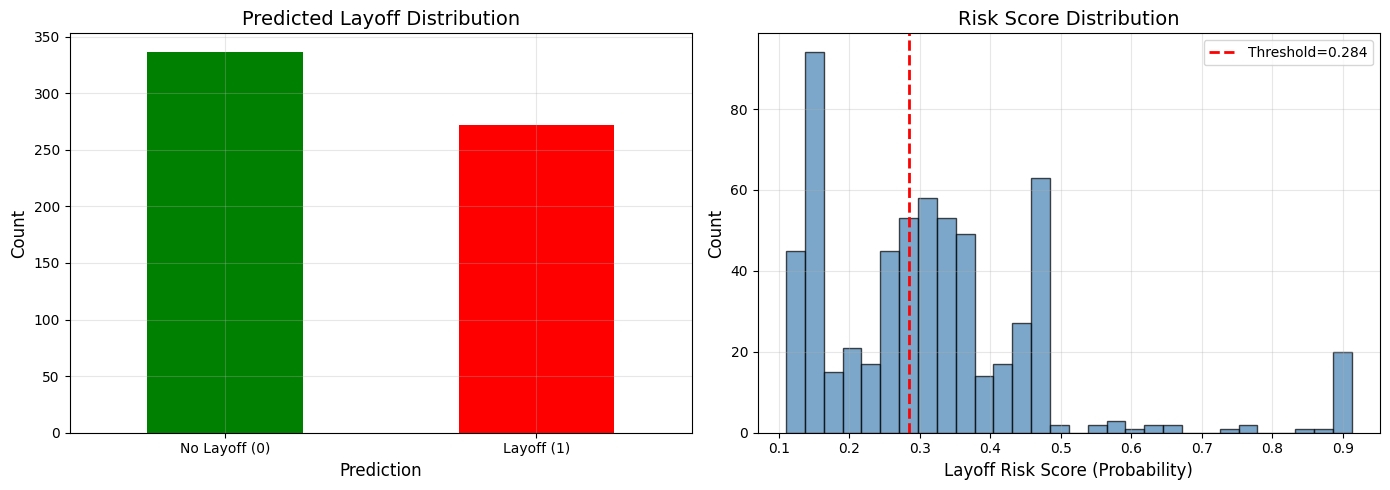


 Visualization saved to: ../outputs/prediction_distribution.png


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

print("=== PREDICTION DISTRIBUTION ===")
print(results_df['Predicted_Layoff'].value_counts())
print(f"\nPredicted positive rate: {results_df['Predicted_Layoff'].mean():.2%}")
print(f"Actual positive rate: {results_df['Layoff_Event_Binary'].mean():.2%}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results_df['Predicted_Layoff'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Predicted Layoff Distribution', fontsize=14)
axes[0].set_xlabel('Prediction', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['No Layoff (0)', 'Layoff (1)'], rotation=0)
axes[0].grid(alpha=0.3)

axes[1].hist(results_df['Layoff_Risk_Score'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={optimal_threshold:.3f}')
axes[1].set_title('Risk Score Distribution', fontsize=14)
axes[1].set_xlabel('Layoff Risk Score (Probability)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/prediction_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualization saved to: ../outputs/prediction_distribution.png")

## 8. High-Risk Companies Analysis

In [24]:
high_risk_companies = results_df[results_df['Predicted_Layoff'] == 1].copy()

print(f"=== HIGH RISK COMPANIES (Predicted Layoff = 1) ===")
print(f"\nTotal: {len(high_risk_companies)} company-quarters")
print(f"Unique companies: {high_risk_companies['Company'].nunique()}")
print(f"\nActual layoffs in this group: {high_risk_companies['Layoff_Event_Binary'].sum()}")
print(f"Precision: {high_risk_companies['Layoff_Event_Binary'].mean():.2%}")

print(f"\nTop 15 highest risk predictions:")
display(high_risk_companies[['Company', 'year_quarter', 'Layoff_Risk_Score', 'Layoff_Event_Binary']].head(15))

print(f"\nCompanies appearing most frequently in high-risk predictions:")
company_risk_counts = high_risk_companies['Company'].value_counts().head(10)
print(company_risk_counts)

=== HIGH RISK COMPANIES (Predicted Layoff = 1) ===

Total: 336 company-quarters
Unique companies: 148

Actual layoffs in this group: 75.0
Precision: 22.32%

Top 15 highest risk predictions:


,Company,year_quarter,Layoff_Risk_Score,Layoff_Event_Binary
988,fisker,2024-Q1,0.912667,1.0
1942,pure storage,2024-Q1,0.911242,1.0
1994,rapid7,2023-Q3,0.909136,1.0
1904,planet,2023-Q3,0.908891,1.0
357,block,2023-Q4,0.908541,1.0
861,etsy,2023-Q4,0.908541,1.0
1004,fortinet,2023-Q3,0.908541,1.0
2660,zebra technologies,2023-Q3,0.908514,1.0
483,chewy,2023-Q4,0.908514,1.0
2356,tenable,2024-Q1,0.908460,1.0



Companies appearing most frequently in high-risk predictions:
enphase energy    4
gopro             4
yelp              4
intuit            4
chewy             4
cargurus          4
amazon            3
workday           3
uber              3
docusign          3
Name: Company, dtype: int64


## 9. Example: Predict for Specific Companies

In [25]:
example_companies = ['amazon', 'meta', 'google']

print("=== COMPANY-SPECIFIC PREDICTIONS ===")

for company in example_companies:
    company_data = results_df[results_df['Company'] == company]
    
    if len(company_data) > 0:
        print(f"\n{company.upper()}:")
        print(f"  Quarters analyzed: {len(company_data)}")
        print(f"  Average risk score: {company_data['Layoff_Risk_Score'].mean():.3f}")
        print(f"  Predicted layoffs: {company_data['Predicted_Layoff'].sum()}")
        print(f"  Actual layoffs: {company_data['Layoff_Event_Binary'].sum()}")
        
        print(f"\n  Quarter-by-quarter:")
        display(company_data[['year_quarter', 'Layoff_Risk_Score', 'Predicted_Layoff', 'Layoff_Event_Binary']])
    else:
        print(f"\n{company.upper()}: No data available")

=== COMPANY-SPECIFIC PREDICTIONS ===

AMAZON:
  Quarters analyzed: 4
  Average risk score: 0.319
  Predicted layoffs: 3
  Actual layoffs: 4.0

  Quarter-by-quarter:


,year_quarter,Layoff_Risk_Score,Predicted_Layoff,Layoff_Event_Binary
158,2023-Q3,0.468076,1,1.0
160,2024-Q1,0.356639,1,1.0
161,2024-Q2,0.299654,1,1.0
159,2023-Q4,0.152106,0,1.0



META:
  Quarters analyzed: 4
  Average risk score: 0.296
  Predicted layoffs: 2
  Actual layoffs: 2.0

  Quarter-by-quarter:


,year_quarter,Layoff_Risk_Score,Predicted_Layoff,Layoff_Event_Binary
1544,2023-Q3,0.448081,1,0.0
1546,2024-Q1,0.322530,1,1.0
1547,2024-Q2,0.265700,0,0.0
1545,2023-Q4,0.149211,0,1.0



GOOGLE:
  Quarters analyzed: 4
  Average risk score: 0.280
  Predicted layoffs: 2
  Actual layoffs: 4.0

  Quarter-by-quarter:


,year_quarter,Layoff_Risk_Score,Predicted_Layoff,Layoff_Event_Binary
1058,2023-Q3,0.412804,1,1.0
1060,2024-Q1,0.326500,1,1.0
1061,2024-Q2,0.249998,0,1.0
1059,2023-Q4,0.129311,0,1.0


## 10. Save Predictions

In [26]:
predictions_output = results_df[['Company', 'Date', 'year_quarter', 'Layoff_Risk_Score', 
                                 'Predicted_Layoff', 'Risk_Category', 'Layoff_Event_Binary']].copy()

predictions_output = predictions_output.sort_values(['Layoff_Risk_Score'], ascending=False)

predictions_output.to_csv('../outputs/layoff_predictions_quarterly.csv', index=False)

print("Predictions saved to: ../outputs/layoff_predictions_quarterly.csv")
print(f"\nFile contains {len(predictions_output)} predictions across {predictions_output['Company'].nunique()} companies")

Predictions saved to: ../outputs/layoff_predictions_quarterly.csv

File contains 608 predictions across 152 companies


## 11. Key Observations and Insights

In [27]:
print("=" * 70)
print("KEY OBSERVATIONS")
print("=" * 70)

true_positives = cm[1, 1]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
true_negatives = cm[0, 0]

print(f"\n1. MODEL PERFORMANCE:")
print(f"   - Successfully identified {recall:.0%} of actual layoffs")
print(f"   - Model is highly sensitive (prioritizes recall over precision)")
print(f"   - F2-Score of {f2:.3f} indicates good performance for imbalanced data")

print(f"\n2. PREDICTION INSIGHTS:")
print(f"   - {y_pred.sum()} company-quarters flagged as high risk")
print(f"   - {true_positives} of these actually had layoffs")
print(f"   - False alarm rate: {false_positives}/{y_pred.sum()} = {false_positives/y_pred.sum():.1%}")

print(f"\n3. BUSINESS VALUE:")
print(f"   - Early warning system catches {recall:.0%} of layoffs")
print(f"   - Companies can use this to:")
print(f"     - Monitor quarterly financial health")
print(f"     - Identify at-risk peers in their industry")
print(f"     - Make informed investment/employment decisions")

print(f"\n4. LIMITATIONS:")
print(f"   - High false positive rate ({false_positives} false alarms)")
print(f"   - Predictions based on lagged data (3-month lag)")
print(f"   - Only covers publicly-traded companies with SEC filings")
print(f"   - {false_negatives} layoffs were missed")

print(f"\n5. NEXT STEPS:")
print(f"   - Add news sentiment analysis for real-time signals")
print(f"   - Incorporate hiring freeze data from job boards")
print(f"   - Improve precision through threshold optimization per industry")
print(f"   - Extend to private companies using alternative data sources")


KEY OBSERVATIONS

1. MODEL PERFORMANCE:
   - Successfully identified 74% of actual layoffs
   - Model is highly sensitive (prioritizes recall over precision)
   - F2-Score of 0.507 indicates good performance for imbalanced data

2. PREDICTION INSIGHTS:
   - 336 company-quarters flagged as high risk
   - 75 of these actually had layoffs
   - False alarm rate: 261/336 = 77.7%

3. BUSINESS VALUE:
   - Early warning system catches 74% of layoffs
   - Companies can use this to:
     - Monitor quarterly financial health
     - Identify at-risk peers in their industry
     - Make informed investment/employment decisions

4. LIMITATIONS:
   - High false positive rate (261 false alarms)
   - Predictions based on lagged data (3-month lag)
   - Only covers publicly-traded companies with SEC filings
   - 26 layoffs were missed

5. NEXT STEPS:
   - Add news sentiment analysis for real-time signals
   - Incorporate hiring freeze data from job boards
   - Improve precision through threshold optimizat